In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast , GradScaler
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import kornia
import kornia.augmentation as K
from torch.functional import F

In [2]:
Test  = "C:/Users/Msi/Desktop/CODE/tamrinecatdog/Test"
trn_dir = "C:/Users/Msi/Desktop/CODE/tamrinecatdog/PetImages"        
vl_dir  = "C:/Users/Msi/Desktop/CODE/tamrinecatdog/ValidationImages"

In [3]:
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.ToTensor()])
class Agumentation(nn.Module):
    def __init__(self , train_mode = True ):
        super().__init__()
        self.train_mode = train_mode
        self.agument = nn.Sequential(K.RandomHorizontalFlip(),
        K.RandomRotation(degrees=20),
        K.ColorJitter(brightness=0.17 , contrast=0.12 , saturation=0.14),
        K.RandomGaussianBlur(kernel_size=(3,3) ,sigma=(0.1, 0.2)),
        K.RandomPerspective(distortion_scale= 0.3))
        self.resize = K.Resize(size=(224, 224))
        self.Normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
    def forward(self , input):
        if self.train_mode == True :
            x=self.agument(input)
        x = self.resize(x)
        x = self.Normalize(x)
        return x

In [4]:
class FocalLoss(nn.Module):
    def __init__(self , gamma = 2.0 , reduction = 'mean' , weight = None ,smoothing = 0.0):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight
        self.smoothing = smoothing
    def forward(self , input , target):
        ce_loss = F.cross_entropy(input , target , weight=self.weight,reduction=
                                                   'none',label_smoothing= self.smoothing)
        pt = torch.exp( - ce_loss)
        
        Focal_loss = ( 1 - pt ) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return Focal_loss.mean()
        elif self.reduction == 'sum' :
            return Focal_loss.sum()
        return Focal_loss
        
        

In [18]:
batch_size = 32
lr = 0.003
num_epochs = 10


test_ds = datasets.ImageFolder(Test ,transform = trans )
trn_ds = datasets.ImageFolder(trn_dir ,transform = trans )
vl_ds = datasets.ImageFolder(vl_dir ,transform = trans)

test_dl = DataLoader(test_ds , batch_size = batch_size , shuffle= False , num_workers = 4 , pin_memory = True)
vl_dl = DataLoader(vl_ds , batch_size = batch_size , shuffle= False , num_workers = 4, pin_memory = True) 
trn_dl = DataLoader(trn_ds , batch_size= batch_size, shuffle= True , num_workers = 4, pin_memory = True) 


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights='DEFAULT')

In [19]:
trainable = ['layer4' , 'fc']
for name,param in model.named_parameters():
    if any(name.startswith(layer) for layer in trainable):
        
        param.requires_grad = True
    else:
        param.requires_grad=False

ftrs_in = model.fc.in_features
model.fc = nn.Linear(ftrs_in,2)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

criterion = FocalLoss(gamma=2 , reduction='mean' , smoothing = 0.12)



scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer , T_max=num_epochs)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
def eval(vl_DL , model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for img , label in vl_DL:
            img , label = img.to(device, non_blocking=True) , label.to(device, non_blocking=True)
            outputs = model(img )
            _, predicted = torch.max(outputs,1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    return correct/total
                    

In [21]:
best_val_acc = 0.0
scaler = GradScaler()
agment = Agumentation(train_mode=True).to(device)
for epoch in range(num_epochs):
    model.train()
    runing_loss = 0.0
    total = 0
    correct = 0 
    for img , label in trn_dl:
        img , label = img.to(device, non_blocking=True) , label.to(device, non_blocking=True)
        img_agment = agment(img)
        
        optimizer.zero_grad()
        
        with autocast("cuda"):
            output = model(img_agment)
            loss = criterion(output , label)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  
        runing_loss += loss.item()
        _ , predicted = torch.max(output,1)
        correct += (predicted == label).sum().item()
        total += label.size(0)
        
    train_accuracy = correct / total
    vl_accuracy=eval(vl_dl, model)
    print(f'Epoch {epoch+1}---train accuracy {train_accuracy:.4f} , validation accuracy {vl_accuracy:.4f}')
    if vl_accuracy > best_val_acc:
        best_val_acc = vl_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved at epoch {epoch+1} with validation accuracy {vl_accuracy:.4f}")


Epoch 1---train accuracy 0.9930 , validation accuracy 0.9667
Model saved at epoch 1 with validation accuracy 0.9667
Epoch 2---train accuracy 0.9956 , validation accuracy 0.9683
Model saved at epoch 2 with validation accuracy 0.9683
Epoch 3---train accuracy 0.9972 , validation accuracy 0.9702
Model saved at epoch 3 with validation accuracy 0.9702
Epoch 4---train accuracy 0.9968 , validation accuracy 0.9692
Epoch 5---train accuracy 0.9972 , validation accuracy 0.9673
Epoch 6---train accuracy 0.9969 , validation accuracy 0.9680
Epoch 7---train accuracy 0.9977 , validation accuracy 0.9563
Epoch 8---train accuracy 0.9976 , validation accuracy 0.9547
Epoch 9---train accuracy 0.9984 , validation accuracy 0.9340
Epoch 10---train accuracy 0.9967 , validation accuracy 0.9580


In [22]:
# بارگذاری بهترین مدل
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


# ارزیابی روی تست
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9690


In [17]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], with_stack=True) as prof:
    with record_function("model_training"):
        for img, label in trn_dl:
            img, label = img.to(device), label.to(device)
            img_agment = agment(img)
            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                output = model(img_agment)
                loss = criterion(output , label)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            break  # فقط یه batch برای تست اجرا کن

# نمایش پروفایل
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         model_training        92.15%       23.710s        99.89%       25.700s       25.700s     102.222ms         3.32%        2.991s        2.991s             1  
                              Optimizer.step#AdamW.step         0.01%       1.657ms         0.01%       3.429ms       3.429ms     122.000us         0.00%        1.374s        1.374s             1  
         

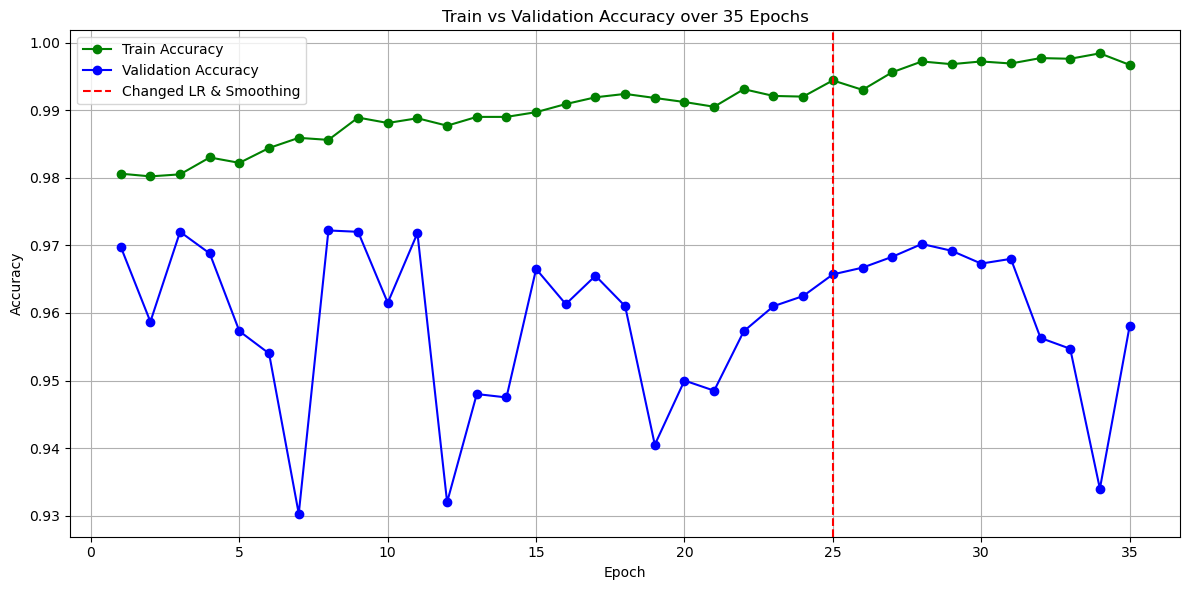

In [24]:
import matplotlib.pyplot as plt

# Train accuracy for all 35 epochs
train_acc = [
    0.9806, 0.9802, 0.9805, 0.9830, 0.9822,
    0.9844, 0.9859, 0.9856, 0.9889, 0.9881,
    0.9888, 0.9877, 0.9890, 0.9890, 0.9897,
    0.9909, 0.9919, 0.9924, 0.9918, 0.9912,
    0.9905, 0.9931, 0.9921, 0.9920, 0.9944,
    0.9930, 0.9956, 0.9972, 0.9968, 0.9972,
    0.9969, 0.9977, 0.9976, 0.9984, 0.9967
]

# Validation accuracy for all 35 epochs
val_acc = [
    0.9698, 0.9587, 0.9720, 0.9688, 0.9573,
    0.9540, 0.9303, 0.9722, 0.9720, 0.9615,
    0.9718, 0.9320, 0.9480, 0.9475, 0.9665,
    0.9613, 0.9655, 0.9610, 0.9405, 0.9500,
    0.9485, 0.9573, 0.9610, 0.9625, 0.9657,
    0.9667, 0.9683, 0.9702, 0.9692, 0.9673,
    0.9680, 0.9563, 0.9547, 0.9340, 0.9580
]

epochs = list(range(1, 36))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, marker='o', linestyle='-', color='green', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', linestyle='-', color='blue', label='Validation Accuracy')

# Mark point of hyperparameter change
plt.axvline(x=25, color='red', linestyle='--', label='Changed LR & Smoothing')

plt.title('Train vs Validation Accuracy over 35 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
